In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [62]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
R = R[P].sub(R[P].mean(1),0)
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [63]:
volume = market_data['volume'].unstack().ffill(limit=5)
close = market_data['close'].unstack()
open = market_data['open'].unstack()
low = market_data['low'].unstack()
high = market_data['high'].unstack()
mean_price = (close+ open + low).fillna(0) / 3


In [84]:
close_low = (close - low).div(close,0)
high_close = (high - close).div(close,0) 
high_low = (high - low).div(close,0) 
diff_1 = close_low - high_close
div_1 = diff_1.div(high_low,0)
mult_1 = volume.mul(div_1,0)
z_score = mult_1.rolling(5).mean()
z_score = z_score.reindex_like(P).ffill()

Sharpe                     1.7
Daily Turnover (%)        69.9
biais (bp)                 2.8
Sharpe since 2022          0.7
biais  since 2022 (bp)     1.1
dtype: float64

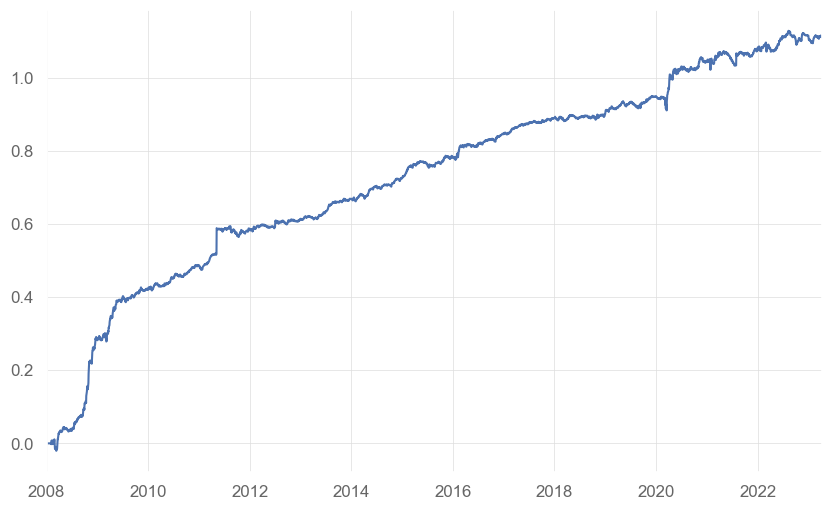

In [94]:
signal = z_score[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R[P]).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)